## Imports

In [1]:
import sys
sys.path.insert(1, "../")

import importlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier

In [2]:
def reload_modules():
    import ghost_unfairness
    importlib.reload(ghost_unfairness.fair_dataset)
    importlib.reload(ghost_unfairness.utils)
    
reload_modules()

from ghost_unfairness.fair_dataset import FairDataset

from ghost_unfairness.utils import *


## Constants

Remeber that after the data is processed, all privileged class values are mapped to 1 and all unprivileged class values are mapped to 0. That means in the following case, after the processing, "Male" will be mapped to 1 and "Female" will be mapped to 0.

In [3]:
protected = ["sex"]
privileged_classes = [['Male']]


privileged_groups = [{key:1 for key in protected}]
unprivileged_groups = [{key:0 for key in protected}]

random_state = 47

## Fair Dataset

In [102]:
fd_train = FairDataset(400, 5, 
                      protected_attribute_names=['sex'],
                      privileged_classes=[['Male']],
                      random_state=random_state)
fd_test = FairDataset(100, 5,
                      protected_attribute_names=['sex'],
                      privileged_classes=[['Male']])

In [103]:
fd_train_x, fd_train_y = fd_train.get_xy(keep_protected = False)
fd_test_x, fd_test_y = fd_test.get_xy(keep_protected = False)

In [104]:
get_dataset_metrics(fd_train,
                    unprivileged_groups,
                    privileged_groups, 
                    verbose=True)

Mean Difference: 0.0
Dataset Base Rate 0.5
Privileged Base Rate 0.5
Protected Base Rate 0.5
Disparate Impact: 1.0


(0.0, 1.0)

### Training Logistic Regression

In [105]:
lmod = LogisticRegression(class_weight='balanced', 
                          solver='liblinear',
                         verbose=2)
lmod.fit(fd_train_x, fd_train_y)

[LibLinear]

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=2,
                   warm_start=False)

In [106]:
get_classifier_metrics(lmod, fd_test,
                       privileged_groups, 
                       unprivileged_groups, 
                       verbose=True)

Mean Difference: 0.03999999999999998
Disparate Impact: 0.0888888888888888
Accuracy: 0.765


(0.03999999999999998, 1.0888888888888888, 0.765)

### Training Decision Tree

In [107]:
dmod = DecisionTreeClassifier(criterion='entropy', 
                                   max_depth=40,
                                  random_state=47)
dmod = dmod.fit(fd_train_x, fd_train_y)

get_classifier_metrics(dmod, fd_test, 
                       privileged_groups, 
                       unprivileged_groups, 
                       verbose=True)

print('Tree Depth:', dmod.get_depth())

Mean Difference: 0.05499999999999999
Disparate Impact: 0.11224489795918369
Accuracy: 0.6325
Tree Depth: 29


### Variation of fairness with model complexity

In [108]:
def train_model_variants(model_type, fd, variant, values,
                        params):
    fd_x, fd_y = fd.get_xy(keep_protected=False)
    models = []
    for val in values:
        model = model_type()
        params[variant] = val
        model.set_params(**params)

        model = model.fit(fd_x, fd_y)
        models.append(model)
        
    return models

In [117]:
def get_model_results(model, train_fd, test_fd, func=None):
    if func:
        model_property = func(model)
    else:
        model_property = None
    
    md, di, ac = get_classifier_metrics(model, train_fd,
                                        privileged_groups, 
                                        unprivileged_groups, 
                                        verbose=True)
    train_result = (md, di, ac, model_property)
    
    print('Test')
    md, di, ac = get_classifier_metrics(model, test_fd,
                                        privileged_groups, 
                                        unprivileged_groups,
                                       verbose=True)
    test_result = (md, di, ac, model_property)
    
    return train_result, test_result

In [118]:
def get_results(models, train_fd, test_fd, func=None):
    train_results = []
    test_results = []
    for model in models:
        train_result, test_result = get_model_results(model, train_fd, 
                                                      test_fd, func)
        train_results.append(train_result)
        test_results.append(test_result)
        
    return train_results, test_results

In [119]:
def decision_tree_property(model):
    return {'depth': model.get_depth()}

In [120]:
max_depths = [3, 5, 10, 15, 20, 40]

params = {'criterion':'entropy',
          'random_state': 47}
variant = 'max_depth'
dmods = train_model_variants(DecisionTreeClassifier,
                            fd_train, variant, max_depths,
                            params)

train_results, test_results = get_results(dmods, fd_train, fd_test,
                                         decision_tree_property)


Mean Difference: 0.0025000000000000022
Disparate Impact: 0.005076142131979711
Accuracy: 0.72375
Test
Mean Difference: 0.06000000000000005
Disparate Impact: 0.11111111111111116
Accuracy: 0.645
Mean Difference: 0.020000000000000018
Disparate Impact: 0.04221635883905006
Accuracy: 0.78125
Test
Mean Difference: 0.02999999999999997
Disparate Impact: 0.06315789473684208
Accuracy: 0.66
Mean Difference: 0.007500000000000007
Disparate Impact: 0.015503875968992276
Accuracy: 0.90625
Test
Mean Difference: 0.0
Disparate Impact: 0.0
Accuracy: 0.645
Mean Difference: 0.011249999999999982
Disparate Impact: 0.022004889975550057
Accuracy: 0.980625
Test
Mean Difference: 0.015000000000000013
Disparate Impact: 0.030612244897959218
Accuracy: 0.5975
Mean Difference: 0.0012499999999999734
Disparate Impact: 0.0024449877750610804
Accuracy: 0.989375
Test
Mean Difference: 0.009999999999999953
Disparate Impact: 0.021052631578947323
Accuracy: 0.615
Mean Difference: 0.0
Disparate Impact: 0.0
Accuracy: 1.0
Test
Mean Di

In [121]:
train_results

[(-0.0025000000000000022, 0.9949238578680203, 0.72375, {'depth': 3}),
 (0.020000000000000018, 1.04221635883905, 0.78125, {'depth': 5}),
 (-0.007500000000000007, 0.9844961240310077, 0.90625, {'depth': 10}),
 (-0.011249999999999982, 0.9779951100244499, 0.980625, {'depth': 15}),
 (-0.0012499999999999734, 0.9975550122249389, 0.989375, {'depth': 20}),
 (0.0, 1.0, 1.0, {'depth': 29})]

In [122]:
test_results

[(-0.06000000000000005, 0.8888888888888888, 0.645, {'depth': 3}),
 (-0.02999999999999997, 0.9368421052631579, 0.66, {'depth': 5}),
 (0.0, 1.0, 0.645, {'depth': 10}),
 (-0.015000000000000013, 0.9693877551020408, 0.5975, {'depth': 15}),
 (-0.009999999999999953, 0.9789473684210527, 0.615, {'depth': 20}),
 (-0.05499999999999999, 0.8877551020408163, 0.6325, {'depth': 29})]

Increasing model complexity tends to increase the disparate impact and mean difference at some point.

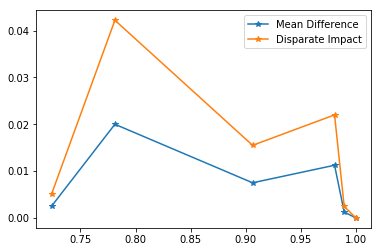

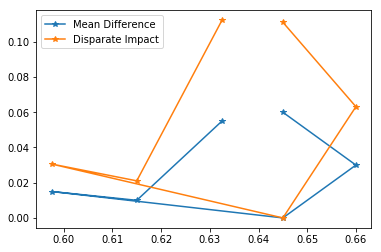

In [123]:
def plot_acc_vs_metric(results):
    mds = [abs(tup[0]) for tup in results]
    dis = [abs(1 - tup[1]) for tup in results]
    acs = [tup[2] for tup in results]
    tds = [tup[3] for tup in results]

    plt.plot(acs, mds, '*-', label='Mean Difference')
    plt.plot(acs, dis, '*-', label='Disparate Impact')
    plt.legend()
    
plot_acc_vs_metric(train_results)
plt.show()
plot_acc_vs_metric(test_results)
plt.show()

Same characteristic can also be seen in the test dataset as well. Trying to increase accuracy in the test dataset also increases the disparate impact and mean difference.

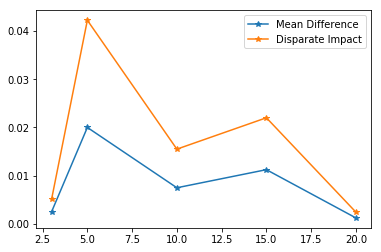

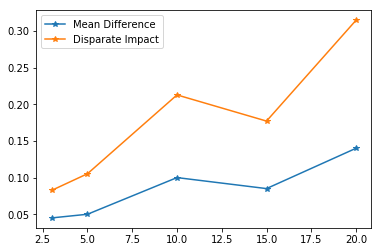

In [79]:
def plot_complexity_vs_metric(results, params):
    mds = [abs(tup[0]) for tup in results]
    dis = [abs(1-tup[1]) for tup in results]
    acs = [tup[2] for tup in results]
    tds = [tup[3] for tup in results]

    plt.plot(params, mds, '*-', label='Mean Difference')
    plt.plot(params, dis, '*-', label='Disparate Impact')
    plt.legend()
    
    
plot_complexity_vs_metric(train_results, max_depths)
plt.show()
plot_complexity_vs_metric(test_results, max_depths)

We want to see group wise accuracy rates for the models.

In [124]:
def get_group_accuracy(model, train_fd):
    train_fd_p = train_fd.get_privileged_group()
    train_fd_u = train_fd.get_unprivileged_group()
    
    _, _, acc_u = get_classifier_metrics(model, train_fd_p,
                        privileged_groups=privileged_groups,
                        unprivileged_groups=unprivileged_groups)
    
    _, _, acc_p = get_classifier_metrics(model, train_fd_u,
                        privileged_groups=privileged_groups,
                        unprivileged_groups=unprivileged_groups)
    return acc_p, acc_u

In [125]:
def get_accuracy_differences(models, train_fd):
    acc_diffs = []
    for model in models:
        acc_p, acc_u = get_group_accuracy(model, train_fd)
        acc_diffs.append(acc_p - acc_u)
        
    return acc_diffs

In [126]:
%%capture --no-stdout
acc_diffs = get_accuracy_differences(dmods, fd_train)
print(acc_diffs)

[0.057499999999999996, 0.030000000000000027, -0.004999999999999893, -0.008750000000000036, -0.0012499999999999734, 0.0]


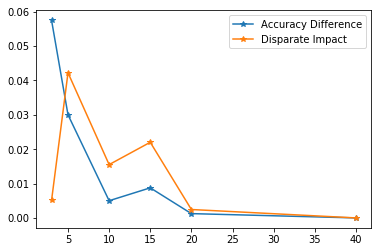

[0.057499999999999996, 0.030000000000000027, -0.004999999999999893, -0.008750000000000036, -0.0012499999999999734, 0.0]


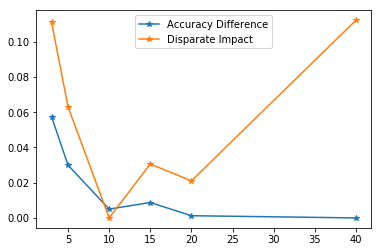

In [127]:
%%capture --no-stdout --no-display
def plot_accuracy_diffrences(results, acc_diffs, values):
    dis = [abs(1 - tup[1]) for tup in results] 
    plt.plot(values, acc_diffs, '*-', label='Accuracy Difference')
    plt.plot(values, dis, '*-', label='Disparate Impact')
    plt.legend()
    
acc_diffs = get_accuracy_differences(dmods, fd_train)
plot_accuracy_diffrences(train_results, np.abs(acc_diffs), max_depths)
plt.show()
plot_accuracy_diffrences(test_results, np.abs(acc_diffs), max_depths)
print(acc_diffs)

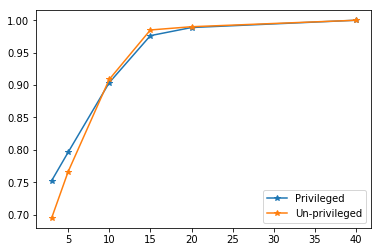

In [128]:
%%capture --no-stdout --no-display
group_accs = [get_group_accuracy(model, fd_train) for model in dmods]
acs_p = [tup[0] for tup in group_accs]
acs_u = [tup[1] for tup in group_accs]
plt.plot(max_depths, acs_p, '*-', label='Privileged')
plt.plot(max_depths, acs_u, '*-', label='Un-privileged')
plt.legend()

### Training with reqularization parameter

In [129]:
def logistic_reg_property(model):
    # TODO: will return theta from this function.
    return {}

In [130]:
regularizers = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]

params = {'class_weight': 'balanced',
          'solver': 'liblinear'}
variant = 'C'
lmods = train_model_variants(LogisticRegression,
                            fd_train, variant, regularizers,
                            params)

lr_train_results, lr_test_results = get_results(lmods, fd_train, fd_test,
                                                logistic_reg_property)


Mean Difference: 0.003750000000000031
Disparate Impact: 0.00540540540540535
Accuracy: 0.695625
Test
Mean Difference: 0.0050000000000000044
Disparate Impact: 0.006993006993006978
Accuracy: 0.7025
Mean Difference: 0.0012499999999999734
Disparate Impact: 0.0018214936247722413
Accuracy: 0.694375
Test
Mean Difference: 0.015000000000000013
Disparate Impact: 0.021276595744680882
Accuracy: 0.7075
Mean Difference: 0.0024999999999999467
Disparate Impact: 0.0039447731755424265
Accuracy: 0.7175
Test
Mean Difference: 0.020000000000000018
Disparate Impact: 0.03007518796992481
Accuracy: 0.735
Mean Difference: 0.003750000000000031
Disparate Impact: 0.006833712984054774
Accuracy: 0.755625
Test
Mean Difference: 0.020000000000000018
Disparate Impact: 0.037735849056603765
Accuracy: 0.76
Mean Difference: 0.010000000000000009
Disparate Impact: 0.01990049751243772
Accuracy: 0.75875
Test
Mean Difference: 0.04999999999999999
Disparate Impact: 0.10989010989010994
Accuracy: 0.76
Mean Difference: 0.00750000000000

In [131]:
print(lr_train_results)
lr_test_results

[(0.003750000000000031, 1.0054054054054054, 0.695625, {}), (0.0012499999999999734, 1.0018214936247722, 0.694375, {}), (0.0024999999999999467, 1.0039447731755424, 0.7175, {}), (0.003750000000000031, 1.0068337129840548, 0.755625, {}), (0.010000000000000009, 1.0199004975124377, 0.75875, {}), (0.007500000000000007, 1.0151133501259446, 0.76, {}), (0.006249999999999922, 1.012594458438287, 0.759375, {}), (0.006249999999999922, 1.012594458438287, 0.759375, {})]


[(-0.0050000000000000044, 0.993006993006993, 0.7025, {}),
 (-0.015000000000000013, 0.9787234042553191, 0.7075, {}),
 (-0.020000000000000018, 0.9699248120300752, 0.735, {}),
 (0.020000000000000018, 1.0377358490566038, 0.76, {}),
 (0.04999999999999999, 1.10989010989011, 0.76, {}),
 (0.03999999999999998, 1.0888888888888888, 0.765, {}),
 (0.044999999999999984, 1.101123595505618, 0.7675, {}),
 (0.044999999999999984, 1.101123595505618, 0.7675, {})]

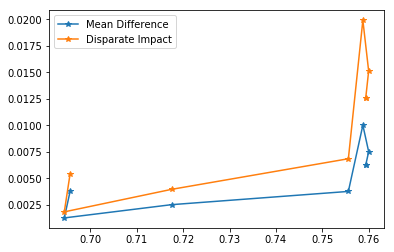

In [132]:
plot_acc_vs_metric(lr_train_results)

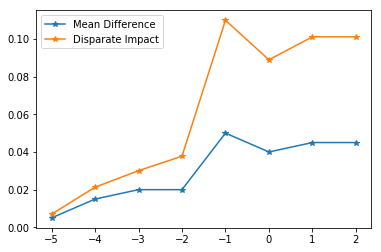

In [133]:
plot_complexity_vs_metric(lr_test_results, np.log10(regularizers))

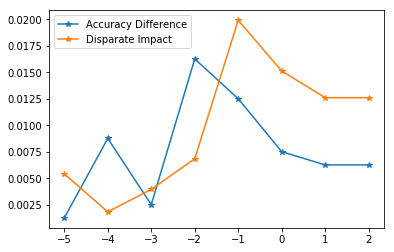

In [135]:
%%capture --no-stdout --no-display
acc_diffs = get_accuracy_differences(lmods, fd_train)
plot_accuracy_diffrences(lr_train_results, np.abs(acc_diffs), np.log10(regularizers))

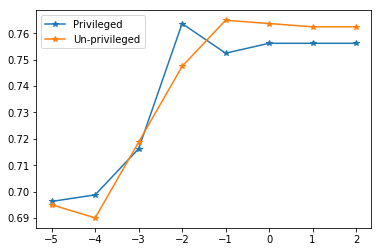

In [136]:
%%capture --no-stdout --no-display
group_accs = [get_group_accuracy(model, fd_train) for model in lmods]
acs_p = [tup[0] for tup in group_accs]
acs_u = [tup[1] for tup in group_accs]
plt.plot(np.log10(regularizers), acs_p, '*-', label='Privileged')
plt.plot(np.log10(regularizers), acs_u, '*-', label='Un-privileged')
plt.legend()

Does test measures average out?

[[0.045      0.06251816 0.6955    ]
 [0.039      0.05485116 0.6975    ]
 [0.055      0.08517284 0.7145    ]
 [0.054      0.09880683 0.737     ]
 [0.062      0.12007407 0.741     ]
 [0.062      0.12209769 0.741     ]
 [0.063      0.12485131 0.7405    ]
 [0.063      0.12485131 0.7405    ]]
[[0.02692582 0.03653047 0.02114829]
 [0.02118962 0.02925035 0.02159282]
 [0.03905125 0.06367018 0.02018044]
 [0.02727636 0.05275526 0.02461707]
 [0.03429286 0.06317249 0.02289105]
 [0.03155947 0.0605591  0.02321637]
 [0.03318132 0.06618289 0.02317865]
 [0.03318132 0.06618289 0.02317865]]


<ErrorbarContainer object of 3 artists>

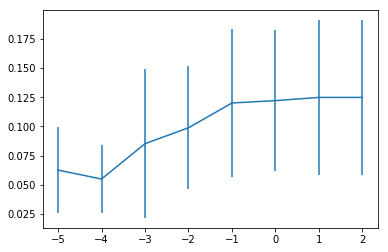

In [137]:
test_fds = []
for i in range(10):
    temp_fd = FairDataset(50, 5,
                          protected_attribute_names=['sex'],
                          privileged_classes=[['Male']],
                          random_state=i)
    test_fds.append(temp_fd)
    # print(temp_fd)
    
    
results = []
for i in range(len(lmods)):
    results.append([])
    for fd in test_fds:
        md, di, acc = get_classifier_metrics(lmods[i], fd,
                                             privileged_groups=privileged_groups,
                                             unprivileged_groups=unprivileged_groups)
               
        
        results[i] += [[abs(md), abs(1-di), acc]]
    
    # print(results[i])

    
results = np.array(results)
means = np.mean(results, axis=1)
variations = np.std(results, axis=1)
# print(results)
print(means)
print(variations)
plt.errorbar(np.log10(regularizers), means[:, 1], yerr=variations[:, 1])

### Bayes Model

In [138]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(fd_train_x, fd_train_y)

gnb_results = []
for fd in test_fds:
    gnb_results.append(get_classifier_metrics(gnb, fd, 
                                 privileged_groups, 
                                 unprivileged_groups))
    print(gnb_results[-1])

(-0.06, 0.875, 0.75)
(-0.05999999999999994, 0.8947368421052633, 0.74)
(0.03999999999999998, 1.0909090909090908, 0.76)
(0.09999999999999998, 1.2127659574468084, 0.76)
(-0.07999999999999996, 0.8750000000000001, 0.74)
(-0.040000000000000036, 0.923076923076923, 0.72)
(0.010000000000000009, 1.0208333333333333, 0.695)
(-0.030000000000000027, 0.94, 0.765)
(-0.10999999999999993, 0.8070175438596492, 0.745)
(0.06000000000000005, 1.1250000000000002, 0.73)


In [139]:
print('Standard Deviation for Bayes classifier Disparate Impact:')
print(np.std([abs(1-tup[1])for tup in gnb_results]))
print(np.mean([abs(1-tup[1])for tup in gnb_results]))

Standard Deviation for Bayes classifier Disparate Impact:
0.054711386262855634
0.11346770726473972
